This is the first experiment trying to apply ML models to local fx (USDCLP). No matters the results:)

In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get and check data

In [43]:
assets = ['CLP=X', 'HG=F']
df = yf.download(assets, period='15y', interval='1d')['Close'] # Close price
df = df.dropna() # delete N/A

[*********************100%%**********************]  2 of 2 completed


In [44]:
df.columns

Index(['CLP=X', 'HG=F'], dtype='object', name='Ticker')

In [45]:
df.shape

(3769, 2)

In [46]:
df.rename(columns={'CLP=X':'usdclp', 'HG=F':'copper'}, inplace=True)

In [47]:
df

Ticker,usdclp,copper
Date,,
2009-05-20,545.830017,2.1085
2009-05-21,540.570007,2.0540
2009-05-22,549.429993,2.1025
2009-05-26,546.260010,2.1475
2009-05-27,560.859985,2.1165
...,...,...
2024-05-14,923.409973,4.9535
2024-05-15,914.080017,4.9695
2024-05-16,904.789978,4.8920


# Create features

In [48]:
## usdclp features
# Returns
df['usdclp_chg%1d'] = df['usdclp'].pct_change() *100
df['usdclp_chg%5d'] = df['usdclp'].pct_change(5) *100
df['usdclp_chg%20d'] = df['usdclp'].pct_change(20) *100
df['usdclp_chg%60d'] = df['usdclp'].pct_change(60) *100
df['usdclp_chg%120d'] = df['usdclp'].pct_change(120) *100

# Moving avarage
df['usdclp_ma5'] = df['usdclp'].rolling(window=5).mean()
df['usdclp_ma20'] = df['usdclp'].rolling(window=20).mean()
df['usdclp_ma60'] = df['usdclp'].rolling(window=60).mean()
df['usdclp_ma120'] = df['usdclp'].rolling(window=120).mean()

In [49]:
## copper features
# Returns
df['copper_chg%1d'] = df['copper'].pct_change() *100
df['copper_chg%5d'] = df['copper'].pct_change(5) *100
df['copper_chg%20d'] = df['copper'].pct_change(20) *100
df['copper_chg%60d'] = df['copper'].pct_change(60) *100
df['copper_chg%120d'] = df['copper'].pct_change(120) *100

# Moving avarage
df['copper_ma5'] = df['copper'].rolling(window=5).mean()
df['copper_ma20'] = df['copper'].rolling(window=20).mean()
df['copper_ma60'] = df['copper'].rolling(window=60).mean()
df['copper_ma120'] = df['copper'].rolling(window=120).mean()

In [50]:
# Create corr columns
df['corr'] = df['usdclp'].corr(df['copper'])
df['corr_5d'] = df['usdclp'].rolling(window=5).corr(df['copper'])
df['corr_20d'] = df['usdclp'].rolling(window=20).corr(df['copper'])
df['corr_60d'] = df['usdclp'].rolling(window=60).corr(df['copper'])
df['corr_120d'] = df['usdclp'].rolling(window=120).corr(df['copper'])

In [51]:
## Create target
df['usdclp+20d'] = df['usdclp'].shift(-20)

In [52]:
df = df.dropna()

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3627 entries, 2009-11-09 to 2024-04-22
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   usdclp           3627 non-null   float64
 1   copper           3627 non-null   float64
 2   usdclp_chg%1d    3627 non-null   float64
 3   usdclp_chg%5d    3627 non-null   float64
 4   usdclp_chg%20d   3627 non-null   float64
 5   usdclp_chg%60d   3627 non-null   float64
 6   usdclp_chg%120d  3627 non-null   float64
 7   usdclp_ma5       3627 non-null   float64
 8   usdclp_ma20      3627 non-null   float64
 9   usdclp_ma60      3627 non-null   float64
 10  usdclp_ma120     3627 non-null   float64
 11  copper_chg%1d    3627 non-null   float64
 12  copper_chg%5d    3627 non-null   float64
 13  copper_chg%20d   3627 non-null   float64
 14  copper_chg%60d   3627 non-null   float64
 15  copper_chg%120d  3627 non-null   float64
 16  copper_ma5       3627 non-null   float64
 

Comments:
- Our target will be the price projected 1 month or 20 days ahead.
- Some features were created, I think they could be related to the objective.

# Exploratory data analysis

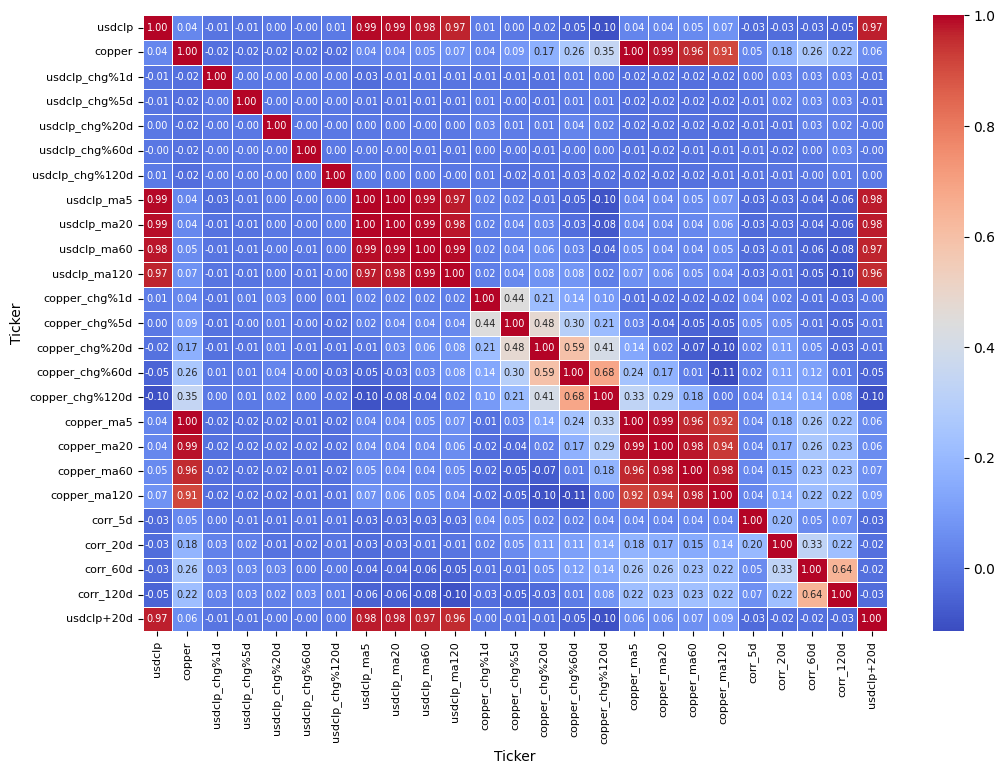

In [54]:
corr = df.drop(columns=['corr']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5, annot_kws={'size':7})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
usdclp,3627.0,655.540110,139.064587,5.000000,516.600006,654.799988,767.149994,1050.260010
copper,3627.0,3.268251,0.662884,1.939500,2.736000,3.213500,3.758500,4.929000
usdclp_chg%1d,3627.0,6.321537,273.326832,-99.246727,-0.462887,0.000000,0.489026,13175.000000
usdclp_chg%5d,3627.0,6.409350,272.981160,-99.240468,-1.036710,0.049748,1.223193,12993.000488
usdclp_chg%20d,3627.0,3.821847,209.871170,-99.261338,-1.729113,0.222909,2.494451,12637.199707
usdclp_chg%60d,3627.0,7.410808,272.992221,-99.242998,-2.483690,0.830445,4.800129,13070.000000
usdclp_chg%120d,3627.0,8.648605,283.849766,-99.232846,-3.528311,1.620605,7.955462,13210.000000
usdclp_ma5,3627.0,655.291177,138.207788,438.622005,514.598996,655.800000,766.189990,1034.362012
usdclp_ma20,3627.0,654.395966,137.214341,456.196001,513.557499,655.542502,766.104572,970.083072


In [56]:
# Delete corr_5d cause has inf values
df.drop(columns=['corr_5d'], axis=1, inplace=True)

# Apply regression models
- We will only apply Random Forest Regressor.

In [57]:
# Create year column to split data
df['year'] = df.index.year

In [58]:
print(df['year'].unique(), '\n')
print(len(df['year'].unique()))

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024] 

16


In [59]:
## Split data
train = df[df['year'] <= 2019]
test = df[df['year'] >= 2020]

y_train = train['usdclp+20d']
X_train = train.drop(['usdclp+20d', 'year'], axis=1)

y_test = test['usdclp+20d']
X_test = test.drop(['usdclp+20d', 'year'], axis=1)

In [60]:
print('Shape X and y train:')
print(X_train.shape, y_train.shape)
print('')
print('Shape X and y test:')
print(X_test.shape, y_test.shape)
print('')
print('Proportion test/train:')
print(round(len(y_test)/len(y_train), 3))

Shape X and y train:
(2543, 24) (2543,)

Shape X and y test:
(1084, 24) (1084,)

Proportion test/train:
0.426


In [61]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

In [62]:
param_rfReg = {'n_estimators':randint(100, 1000),
               'max_depth':randint(1, 10)}

rand_search_rfReg = RandomizedSearchCV(RandomForestRegressor(),
                                       param_distributions=param_rfReg,
                                       n_iter=5,
                                       cv=5,
                                       random_state=123)

In [63]:
rand_search_rfReg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eabe85d2dd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eabe2553400>},
                   random_state=123)

In [64]:
print('Best hiperparameters:', rand_search_rfReg.best_params_)

Best hiperparameters: {'max_depth': 1, 'n_estimators': 213}


In [65]:
## Create model
rfReg = RandomForestRegressor(n_estimators=213,
                              max_depth=1,
                              random_state=123)

rfReg.fit(X_train, y_train) # Adjust model

RandomForestRegressor(max_depth=1, n_estimators=213, random_state=123)

In [66]:
y_rfReg = rfReg.predict(X_test)

# Analyze results

In [67]:
mse = mean_squared_error(y_test, y_rfReg)
print('Error cuadrático medio:', mse)

Error cuadrático medio: 33609.71917652733


In [68]:
from math import sqrt
rmse = sqrt(mse)
print('Raíz del error cuadrático medio:', rmse)

Raíz del error cuadrático medio: 183.32953710880125


In [69]:
r2 = r2_score(y_test, y_rfReg)
print('Coeficiente de determinación (R^2):', r2)

Coeficiente de determinación (R^2): -5.43604860877019


In [70]:
# Create df with predictions
results_rfReg = pd.DataFrame({'y_test':y_test, 'predictions':y_rfReg}, index=y_test.index)
usdclp = df['usdclp']

In [71]:
y_test.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12',
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22'],
              dtype='datetime64[ns]', name='Date', length=1084, freq=None)

In [72]:
results_rfReg

,y_test,predictions
Date,,
2020-01-02,796.799988,659.959238
2020-01-03,799.799988,659.959238
2020-01-06,787.000000,659.959238
2020-01-07,781.200012,659.959238
2020-01-08,776.200012,659.959238
...,...,...
2024-04-16,923.409973,659.959238
2024-04-17,914.080017,659.959238
2024-04-18,904.789978,659.959238


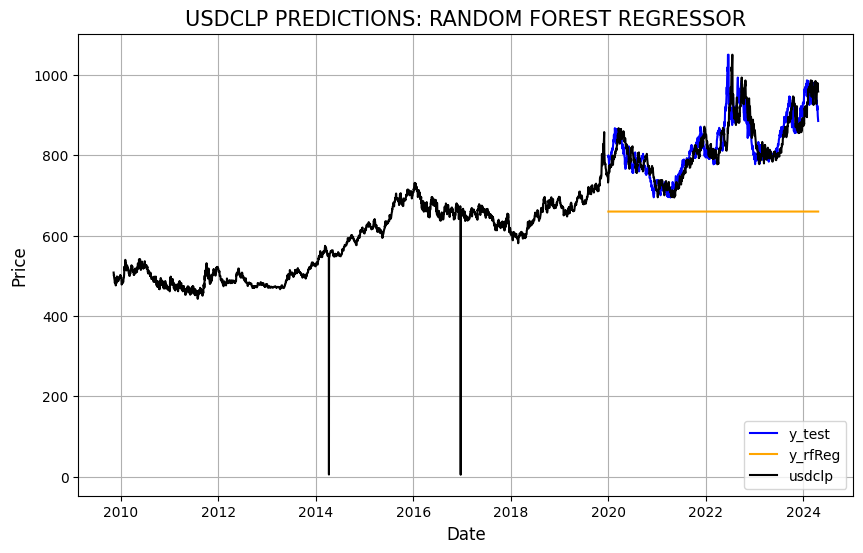

In [41]:
plt.figure(figsize=(10, 6))
plt.title('USDCLP PREDICTIONS: RANDOM FOREST REGRESSOR', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.plot(results_rfReg.index, results_rfReg['y_test'], label='y_test', color='blue')
plt.plot(results_rfReg.index, results_rfReg['predictions'], label='y_rfReg', color='orange')
plt.plot(usdclp.index, usdclp, label='usdclp', color='black')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Final comments:
- Sucks:D